## Using Trigger to identify raman pulses region in pkl files

In [89]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean

In [95]:
survey_data_folder_path = r'C:\Users\vaish\dsvv_atomionics\Survey_Data'
columns = ["APD", "CA+", "CA-", "Trigger"]

In [96]:
experiment_id = '011_001'
master_run = '15795'

In [97]:
data0_file_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run, 'data0.pkl')
data1_file_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run, 'data1.pkl')
data2_file_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run, 'data2.pkl')
data0 = pd.DataFrame(pd.read_pickle(data0_file_path), columns=columns)
data1 = pd.DataFrame(pd.read_pickle(data1_file_path), columns=columns)
data2 = pd.DataFrame(pd.read_pickle(data2_file_path), columns=columns)

In [98]:
# Given a dataframe -> returns a list of windows around raman pulses
def get_raman_pulse_windows(data, window_size=1000, step_size=50):
	# find windows where max trigger value > 20000, and highlight on the plot
	trigger_values = data['Trigger']

	maximum_values = [trigger_values.iloc[i:i+window_size].max() for i in range(0, len(trigger_values) - window_size, step_size)]
	maximum_values_df = pd.DataFrame(maximum_values, columns=['Max Trigger Value'])

	# Add the starting index of the current window
	maximum_values_df['Starting Index'] = maximum_values_df.index * step_size

	# Filter out windows where max trigger value > 20000
	high_trigger_windows = maximum_values_df[maximum_values_df['Max Trigger Value'] > 20000]

	# combine all overlapping windows, eg: [1, 2], [2, 3] -> [1, 3]
	current_window_begin = -1
	current_window_end = -1
	combined_windows = []
	for i in range(len(high_trigger_windows)):
		if i == 0:
			current_window_begin = high_trigger_windows['Starting Index'].iloc[i]
			current_window_end = high_trigger_windows['Starting Index'].iloc[i] + window_size
		else:
			if high_trigger_windows['Starting Index'].iloc[i] <= current_window_end:
				current_window_end = high_trigger_windows['Starting Index'].iloc[i] + window_size
			else:
				combined_windows.append((current_window_begin, current_window_end))
				current_window_begin = high_trigger_windows['Starting Index'].iloc[i]
				current_window_end = high_trigger_windows['Starting Index'].iloc[i] + window_size
		if i == len(high_trigger_windows) - 1:
			combined_windows.append((current_window_begin, current_window_end))

	# filter out windows at even indices
	combined_windows = combined_windows[0::2]
	return combined_windows

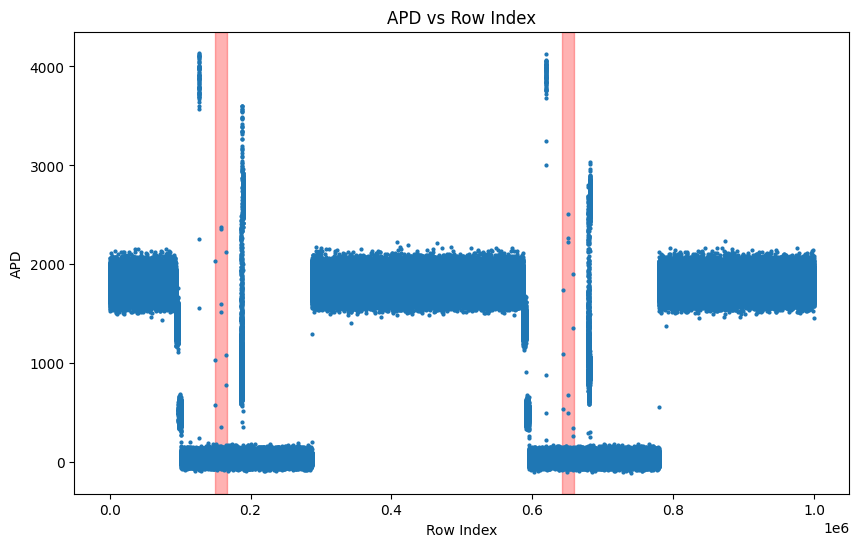

In [99]:
test_subset = data0.iloc[0:int(1e6)]
test_windows = get_raman_pulse_windows(test_subset)

# plot
plt.figure(figsize=(10, 6))
plt.plot(test_subset.index, test_subset['APD'], 'o', markersize=2)
plt.xlabel('Row Index')
plt.ylabel('APD')
plt.title('APD vs Row Index')

# Highlight raman windows
for window in test_windows:
	plt.axvspan(window[0], window[1], color='red', alpha=0.3)

plt.show()

In [100]:
# count number of windows across all data files
window_size = 10000
step_size = 5000
combined_windows_data0 = get_raman_pulse_windows(data0, window_size, step_size)
combined_windows_data1 = get_raman_pulse_windows(data1, window_size, step_size)
combined_windows_data2 = get_raman_pulse_windows(data2, window_size, step_size)

print(f'total number of windows in data0: {len(combined_windows_data0)}')
print(f'total number of windows in data1: {len(combined_windows_data1)}')
print(f'total number of windows in data2: {len(combined_windows_data2)}')
print(f'total number of windows across all data files: {len(combined_windows_data0) + len(combined_windows_data1) + len(combined_windows_data2)}')

total number of windows in data0: 64
total number of windows in data1: 64
total number of windows in data2: 30
total number of windows across all data files: 158


# Derive statistics for CA+ and CA-

In [120]:
stat_columns = [
    'CA+_mean', 'CA+_std_dev', 'CA+_percentile_0', 'CA+_percentile_10', 'CA+_percentile_20', 
    'CA+_percentile_30', 'CA+_percentile_40', 'CA+_percentile_50', 'CA+_percentile_60', 'CA+_percentile_70', 
    'CA+_percentile_80', 'CA+_percentile_90', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 'CA-_percentile_10', 'CA-_percentile_20', 'CA-_percentile_30', 
    'CA-_percentile_40', 'CA-_percentile_50', 'CA-_percentile_60', 'CA-_percentile_70', 'CA-_percentile_80', 
    'CA-_percentile_90', 'CA-_percentile_100'
]

In [114]:
# Given a list of values, returns a list [mean, geometric_mean or 0, std. deviation, 0th percentile, 10th percentile... 100th percentile]
def get_stats(values):
	stats = []
	stats.append(np.mean(values))
	stats.append(np.std(values))
	for i in range(0, 101, 10):
		stats.append(np.percentile(values, i))
	return stats

In [121]:
# Given a dataframe and a list of raman windows, returns a list of stats for CA+ and CA- each window
def get_window_stats_from_dataframe(data, windows):
	window_stats = []
	for window in windows:
		window_data_ca_plus = data['CA+'].iloc[window[0]:window[1]]
		window_data_ca_minus = data['CA+'].iloc[window[0]:window[1]]
		ca_plus_ca_minus_combined_stats = get_stats(window_data_ca_plus)
		ca_plus_ca_minus_combined_stats.extend(get_stats(window_data_ca_minus))
		window_stats.append(ca_plus_ca_minus_combined_stats)
	stats_df = pd.DataFrame(window_stats, columns=stat_columns)
	return stats_df

In [124]:
test_statistics = get_window_stats_from_dataframe(test_subset, test_windows)
print(test_statistics.head())

      CA+_mean  CA+_std_dev  CA+_percentile_0  CA+_percentile_10  \
0  4271.655457  2025.222384           -3526.0             1709.6   
1  4255.036941  2013.085570           -3490.0             1710.0   

   CA+_percentile_20  CA+_percentile_30  CA+_percentile_40  CA+_percentile_50  \
0             2575.0             3207.0             3755.0             4282.0   
1             2591.0             3215.0             3746.0             4233.0   

   CA+_percentile_60  CA+_percentile_70  ...  CA-_percentile_10  \
0             4793.0             5312.0  ...             1709.6   
1             4728.0             5260.0  ...             1710.0   

   CA-_percentile_20  CA-_percentile_30  CA-_percentile_40  CA-_percentile_50  \
0             2575.0             3207.0             3755.0             4282.0   
1             2591.0             3215.0             3746.0             4233.0   

   CA-_percentile_60  CA-_percentile_70  CA-_percentile_80  CA-_percentile_90  \
0             4793.0    

# Pick out relevant columns from the csv

In [110]:
# Given a csv file path, returns a datafram only containing the columns: master_run_number, var1, fraction
def get_data_from_csv(csv_file_path):
	df = pd.read_csv(csv_file_path)
	df = df[['master_run_number', 'var1', 'fraction']]
	df = df.rename(columns={'var1': 'chirp_rate'})
	return df

In [111]:
sample_csv_file_path = r'C:\Users\vaish\dsvv_atomionics\Survey_Data\011_001\chirp_down\fringes_data.csv'
sample_data = get_data_from_csv(sample_csv_file_path)

print(sample_data.shape)
print(sample_data.head())

(79, 3)
   master_run_number  chirp_rate  fraction
0              15795   -25.09473  0.592062
1              15795   -25.09340  0.558413
2              15795   -25.09312  0.489731
3              15795   -25.09172  0.452956
4              15795   -25.09536  0.525355


# Putting It All Together

For each `master_run`:
- Get `data0`, `data1`, `data2`
- Get `windows0`, `windows1`, `windows2`
- Get `window_stats0`, `window_stats1`, `window_stats2`
- Combine `window_stats0`, `window_stats1`, `window_stats2` into `combined_window_stats`
- `chirp_up_window_stats = combined_window_stats[0::2]`
- `chirp_down_window_stats = combined_window_stats[1::2]`
- Get `chirp_up_data` from `chirp_up_csv_path`
- Get `chirp_down_data` from `chirp_down_csv_path`
- Append `chirp_up_window_stats` to `chirp_up_data`
- Append `chirp_down_window_stats` to `chirp_down_data`
- Combine both dataframes 
- Save the combined dataframe to `compiled_data\master_run.csv`


In [134]:
def create_compiled_data(master_run):
	experiment_id = "011_{:03d}".format(master_run - 15794)
	master_run = str(master_run)
	print("master_run = ", master_run) 
	print("experiment_id = ", experiment_id)
	pkl_folder_path = os.path.join(survey_data_folder_path, experiment_id, "raw_data", master_run)
	data0_file_path = os.path.join(pkl_folder_path, 'data0.pkl')
	data1_file_path = os.path.join(pkl_folder_path, 'data1.pkl')
	data2_file_path = os.path.join(pkl_folder_path, 'data2.pkl')
	data0 = pd.DataFrame(pd.read_pickle(data0_file_path), columns=columns)
	data1 = pd.DataFrame(pd.read_pickle(data1_file_path), columns=columns)
	data2 = pd.DataFrame(pd.read_pickle(data2_file_path), columns=columns)

	raman_windows_data0 = get_raman_pulse_windows(data0)
	print(f'number of raman windows in data0: {len(raman_windows_data0)}')
	raman_windows_data1 = get_raman_pulse_windows(data1)
	print(f'number of raman windows in data1: {len(raman_windows_data1)}')
	raman_windows_data2 = get_raman_pulse_windows(data2)
	print(f'number of raman windows in data2: {len(raman_windows_data2)}')

	raman_window_stats_data0 = get_window_stats_from_dataframe(data0, raman_windows_data0)
	raman_window_stats_data1 = get_window_stats_from_dataframe(data1, raman_windows_data1)
	raman_window_stats_data2 = get_window_stats_from_dataframe(data2, raman_windows_data2)

	combined_raman_window_stats = pd.concat([raman_window_stats_data0, raman_window_stats_data1, raman_window_stats_data2])

	chirp_up_raman_window_stats = combined_raman_window_stats.iloc[0::2]
	print(f'number of chirp up raman windows: {len(chirp_up_raman_window_stats)}')
	chirp_down_raman_window_stats = combined_raman_window_stats.iloc[1::2]
	print(f'number of chirp down raman windows: {len(chirp_down_raman_window_stats)}')

	chirp_up_csv_file_path = os.path.join(survey_data_folder_path, experiment_id, 'chirp_up', 'fringes_data.csv')
	chirp_down_csv_file_path = os.path.join(survey_data_folder_path, experiment_id, 'chirp_down', 'fringes_data.csv')
	chirp_up_data = get_data_from_csv(chirp_up_csv_file_path)
	chirp_down_data = get_data_from_csv(chirp_down_csv_file_path)

	print('chirp_up data:')
	print(chirp_up_data.head())
	print('chirp_down data:')
	print(chirp_down_data.head())

	chirp_up_data_with_raman_stats = chirp_up_data.join(chirp_up_raman_window_stats)
	chirp_down_data_with_raman_stats = chirp_down_data.join(chirp_down_raman_window_stats)
	print('chirp_up data with raman stats:')
	print(chirp_up_data_with_raman_stats.head())
	print('chirp_down data with raman stats:')
	print(chirp_down_data_with_raman_stats.head())

	compiled_data_for_master_run = pd.concat([chirp_up_data_with_raman_stats, chirp_down_data_with_raman_stats])
	print('compiled data for master run:')
	print(compiled_data_for_master_run.head())

	# save compiled data to csv in '/compiled_data/master_run.csv'
	compiled_data_csv_file_path = os.path.join(r'C:\Users\vaish\dsvv_atomionics', 'compiled_data', f'{master_run}.csv')
	compiled_data_for_master_run.to_csv(compiled_data_csv_file_path, index=False)							


In [136]:
create_compiled_data(15795)

master_run =  15795
experiment_id =  011_001
number of raman windows in data0: 64
number of raman windows in data1: 64
number of raman windows in data2: 30
number of chirp up raman windows: 79
number of chirp down raman windows: 79
chirp_up data:
   master_run_number  chirp_rate  fraction
0              15795    25.09374  0.435512
1              15795    25.09647  0.595626
2              15795    25.09311  0.435637
3              15795    25.09192  0.638270
4              15795    25.09661  0.560878
chirp_down data:
   master_run_number  chirp_rate  fraction
0              15795   -25.09473  0.592062
1              15795   -25.09340  0.558413
2              15795   -25.09312  0.489731
3              15795   -25.09172  0.452956
4              15795   -25.09536  0.525355
chirp_up data with raman stats:
   master_run_number  chirp_rate  fraction     CA+_mean  CA+_std_dev  \
0              15795    25.09374  0.435512  4271.655457  2025.222384   
0              15795    25.09374  0.435512  